Model of shoaling behavior based on the Boids model by Craig Reynolds in 1986, using the 
basic code provided in the Flocker example of the Mesa framework for agent-based modelling in Python. This model is based on 2 parameters that each agent follows:
    1. Attraction to other agents,
    2. Avoidance of other agents.
    
Heading, though recorded for each agent, is not included in the parameters that determine
an agents' movement. Therefore, polarization becomes an emergent behaviour and can be 
analyzed as a measure of cohesion, along with the nearest neighbour distance. The model is based on a bounded, 3D area. Later additions will include obstacles, environmental
gradients, and agents with goal-, food-, or safety-seeking behaviour.

This Jupyter notebook version is useful for changing the parameters of the model and seeingthe effect on cohesion without having to re-write the model each time. Parameters explored here include vision and number of individuals and the effect these parameters have on
cohesion. 

In [13]:
# Packages and libraries
import numpy as np
import random
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import ContinuousSpace
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import matplotlib.pyplot as plt

In [14]:
def polar(model):
    """
    Computes polarization of the agents by averaging their headings,
    from 0 to 1. As the value approaches 1, the cohesion of the shoal increases.
    Heading is a unit vector, meaning the magnitude is 1 and the direction is
    given as x,y coordinates. The average is taken first of the absolute value
    of the x-coordinate, then of the y-coordinate and then those averages are
    averaged to find a single number to represent on the graph. This might not
    be mathematically accurate!
    """
    heading_x = [agent.heading[0] for agent in model.schedule.agents]
    heading_y = [agent.heading[1] for agent in model.schedule.agents]
    num_fish = model.num_agents
    avg_h_x = abs(sum(heading_x))/num_fish
    avg_h_y = abs(sum(heading_y))/num_fish
    avg_heading = (avg_h_x + avg_h_y)/2

    return avg_heading

In [15]:
# Defines the Agent class for the "fish" in the model
class Fish(Agent):
    """
    A Boid-style agent. Boids have a vision that defines the radius in which
    they look for their neighbors to flock with. The units of this vision are
    unclear, however. Their speed (a scalar) and heading (a unit vector) define
    their movement. Avoidance is their desired minimum distance from any other agent.
    """
    def __init__(self, unique_id, model, pos, speed=5, heading=None,
                 vision=5, avoidance=1):
        """
        Create a new Boid agent. Args:
            unique_id: Unique agent identifier.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Boids.
            avoidance: Minimum distance to maintain from other Boids.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.speed = speed
        if heading is not None:
            self.heading = heading
        else:
            self.heading = np.random.random(2)
            self.heading /= np.linalg.norm(self.heading)
        self.vision = vision
        self.avoidance = avoidance

    def cohere(self, neighbors):
        """ Return the vector toward the center of mass of the local neighbors. """
        center = np.array([0.0, 0.0])
        for neighbor in neighbors:
            center += np.array(neighbor.pos)
        return center / len(neighbors)

    def separate(self, neighbors):
        """ Return a vector away from any neighbors closer than avoidance dist. """
        my_pos = np.array(self.pos)
        sep_vector = np.array([0, 0])
        for neighbor in neighbors:
            their_pos = np.array(neighbor.pos)
            dist = np.linalg.norm(my_pos - their_pos)
            if dist < self.avoidance:
                sep_vector -= np.int64(their_pos - my_pos)
        return sep_vector

    def step(self):
        """
        Get the Boid's neighbors, compute the new vector, and move accordingly,
        but the agents no longer attempt to match their heading to others.
        Their new heading is dependent on their desire ot cohere & to separate.
        """
        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        if len(neighbors) > 0:
            cohere_vector = self.cohere(neighbors)
            separate_vector = self.separate(neighbors)
            self.heading += (cohere_vector +
                             separate_vector)
            self.heading /= np.linalg.norm(self.heading)
        new_pos = np.array(self.pos) + self.heading * self.speed
        new_x, new_y = new_pos
        self.model.space.move_agent(self, (new_x, new_y))

In [16]:
# Defines the collective behaviour model
class ShoalModel(Model):
    """ Shoal model class. Handles agent creation, placement and scheduling. """

    def __init__(self, n, width, height, speed, vision, avoidance):
        """
        Create a new Flockers model. Args:
            N: Number of agents
            width, height: Size of the space.
            speed: How fast should the agents move.
            vision: How far around should each agent should look for its
                    neighbors
            avoidance: What's the minimum distance each agent will attempt to
                       keep from any other
                       
        Also includes data collection for analysis of the model.
        """
        self.num_agents = n
        self.vision = vision
        self.speed = speed
        self.avoidance = avoidance
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, True,
                                     grid_width=10, grid_height=10)
        self.running = True

        for i in range(self.num_agents):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            heading = np.random.random(2) * 2 - np.array((1, 1))
            heading /= np.linalg.norm(heading)
            fish = Fish(i, self, pos, self.speed, heading, self.vision,
                        self.avoidance)
            self.space.place_agent(fish, pos)
            self.schedule.add(fish)
        
        # Creating the data collector, which reports the output of a function
        # (polar, the average agent heading) for each step of the model. This
        # is a "model-level" reporter, but agent-level is also available.
        self.datacollector = DataCollector(
            model_reporters={"Polarization": polar})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [17]:
# Runs the model with the following parameters:
#   1. Number of agents
#   2. Width
#   3. Height
#   4. Speed
#   5. Vision
#   6. Avoidance
# and then runs the model for (n) steps.
model = ShoalModel(100, 100, 100, 5, 5, 2)
for i in range(100):
    model.step()

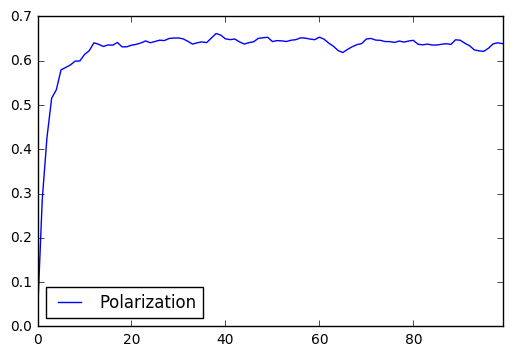

In [18]:
# Plot cohesion factor
%matplotlib inline

polarization = model.datacollector.get_model_vars_dataframe()
polarization.plot()